# <span style="color:blue;">OpenPIV-Python-GPU Batching Tutorial</span>

Please use the following link to run this notebook from Google Colab:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ali-sh-96/openpiv-python-gpu/blob/main/openpiv_gpu/tutorials/openpiv_python_gpu_batching_tutorial.ipynb)

## <span style="color:blue;">Introduction</span>

This tutorial demonstrates how to use the `batch_size` parameter in OpenPIV-Python-GPU for for an optimal particle image velocimetry (PIV) analysis. The data used here is the low Reynolds number separated flow over an airfoil (acquired in the Turbulence Research Lab, University of Toronto). The images are 2052 by 4606 pixels squared and approximately 13.9 MB in size. The output from the PIV analyses is displayed as vector plots and the computation time for different values of `batch_size` is compared.


In `openpiv-python-gpu`, during each iteration, the algorithm generates two 3D stacks of square regions around measurement nodes, referred to as interrogation windows, for every image. Subsequently, the velocity field is estimated by computing the cross-correlation of these two stacks. The cross-correlation process can be executed either entirely in serial mode or in parallel mode by setting `batch_size=1` or `batch_size=`_`"full"`_, respectively. An alternative approach involves a hybrid mode, where the cross-correlation is conducted serially for slices of the original 3D stack. Ideally, `batch_size=`_`"full"`_ is preferred for GPU utilization. However, memory constraints may render this option impractical, particularly with large images or when using double-precision floating-point data types. In such cases, optimizing the batch size before processing the entire set of image pairs becomes necessary.

## <span style="color:blue;">Dependencies</span>

The `openpiv-python-gpu` package only depends on `cupy`, `numpy`, and `scipy`, all of which are already preinstalled on colaboratory. The choice of other libraries, such as those needed to load or save images, is left to the users. In this tutorial, opencv-python is used to load images.

In [1]:
#@title Import the needed libraries
#@markdown Run this block to import the dependencies.
import sys
import os
from glob import glob
import cv2
import time

import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as display

In [2]:
#@title Install `openpiv-python-gpu`
#@markdown Run this block to install `openpiv-python-gpu`.
!git clone https://github.com/ali-sh-96/openpiv-python-gpu
openpiv_path = "/content/openpiv-python-gpu/"
sys.path.append(openpiv_path)
from openpiv_gpu.gpu_process import piv_gpu

# Get the path to the tutorials folder.
tutorial_path = os.path.join(openpiv_path, 'openpiv_gpu/tutorials/')

Cloning into 'openpiv-python-gpu'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 70 (delta 24), reused 58 (delta 16), pack-reused 0
Receiving objects: 100% (70/70), 30.24 MiB | 13.28 MiB/s, done.
Resolving deltas: 100% (24/24), done.


## <span style="color:blue;">Separated Flow Test Case</span>

This section demonstrates the usage of the module for a pair of actual PIV images obtained for studying low Reynolds number separated flow over an airfoil. An airfoil mask is used to cover the airfoil on the images. The goal is to resolve the velocity field to a window size of 16 pixels.

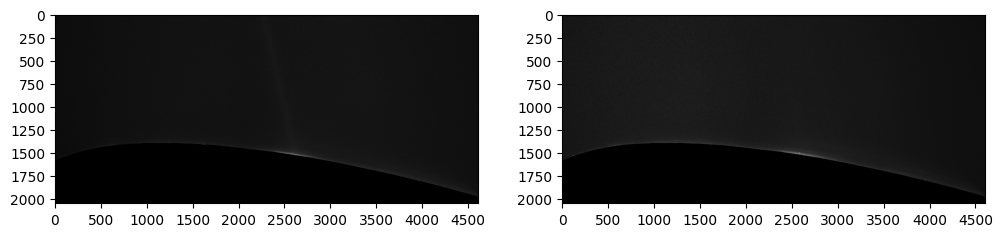

In [3]:
#@title Load the images
# Load the images.
test_dir = tutorial_path + "test2/"
tif_files = glob(os.path.join(test_dir + '*.tif'))

# Show the images.
frame_a = cv2.imread(tif_files[0], cv2.IMREAD_ANYDEPTH)
frame_b = cv2.imread(tif_files[1], cv2.IMREAD_ANYDEPTH)

fig, axs = plt.subplots(1, 2, figsize=(12,10))
axs[0].imshow(frame_a, cmap=plt.cm.gray)
axs[1].imshow(frame_b, cmap=plt.cm.gray)

# Modify tick labels and ticks.
tick_step = 250
ht, wd = frame_a.shape
for ax in axs:
    ax.set_xticks(range(0, wd, 2 * tick_step))
    ax.set_yticks(range(0, ht, tick_step))

plt.show()

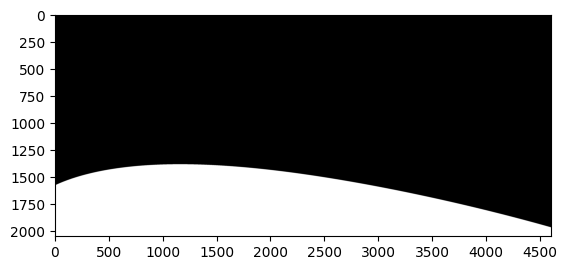

In [4]:
#@title Load the mask
# Load the airfoil mask.
mask = cv2.imread(test_dir + "airfoil_mask.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(mask, cmap=plt.cm.gray)

# Modify tick labels and ticks.
tick_step = 250
plt.xticks(range(0, wd, 2 * tick_step))
plt.yticks(range(0, ht, tick_step))
plt.show()

In [5]:
#@title PIV settings
#@markdown The shape of the images is `(2052, 4603)`.
frame_shape = (2052, 4603) #@param {type:"raw"}
min_search_size = 16 #@param [8, 16, 32] {type:"raw"}
search_size_iters = (1, 2, 2,) #@param {type:"raw"}
batch_size = 1000 #@param {type:"raw"}
mask = mask #@param {type:"raw"}

In [6]:
#@title Perform PIV processing
#@markdown Run this block to process the images for the first time.
# Initialize the process.
process = piv_gpu(frame_shape,
                  min_search_size=16,
                  batch_size=500,
                  search_size_iters=(1, 2, 2),
                  mask=mask)

# Get the field coordinates.
x, y = process.coords

# Invert the y axis.
y = y[::-1]

# Process the images.
start_time = time.time()
u, v = process(frame_a, frame_b)
v = -v

# Printout the computation time.
process_time = time.time() - start_time
print('First time compilation is done.')

First time compilation is done.


Note that it takes a long time to process the first image on the GPU since CUDA kernels need to be compiled before execution. Now that CUDA kernels are compiled, we may compare the GPU performance for different values of `batch_size`.

In [7]:
#@title Perform PIV processing
#@markdown Run this block to process the images for the second time.
batch_size = 1000 #@param {type:"raw"}

# Initialize the process.
process = piv_gpu(frame_shape,
                  min_search_size=16,
                  batch_size=batch_size,
                  search_size_iters=(1, 2, 2),
                  mask=mask)

# Get the field coordinates.
x, y = process.coords

# Invert the y axis.
y = y[::-1]

# Process the images.
start_time = time.time()
u, v = process(frame_a, frame_b)
v = -v

# Printout the computation time.
process_time = time.time() - start_time
print('Computation time for {} image pair was {:.3f} s.'.format(1, process_time))

# Get the locations of the unreliable vectors.
loc = process.val_locations
_loc = ~loc

Computation time for 1 image pair was 2.108 s.


In [8]:
#@title Perform PIV processing
#@markdown Run this block to process the images for the third time.
batch_size = 100 #@param {type:"raw"}

# Initialize the process.
process = piv_gpu(frame_shape,
                  min_search_size=16,
                  batch_size=batch_size,
                  search_size_iters=(1, 2, 2),
                  mask=mask,)

# Get the field coordinates.
x, y = process.coords

# Invert the y axis.
y = y[::-1]

# Process the images.
start_time = time.time()
u, v = process(frame_a, frame_b)
v = -v

# Printout the computation time.
process_time = time.time() - start_time
print('Computation time for {} image pair was {:.3f} s.'.format(1, process_time))

# Get the locations of the unreliable vectors.
loc = process.val_locations
_loc = ~loc

Computation time for 1 image pair was 2.979 s.


From the aforementioned experiment, it's evident that setting `batch_size=1000` resulted in improved computation time compared to batch_size=100. It's important to note that using `batch_size=`_`"full"`_ triggers a memory limitation error on the T4 GPU within Google Colab.

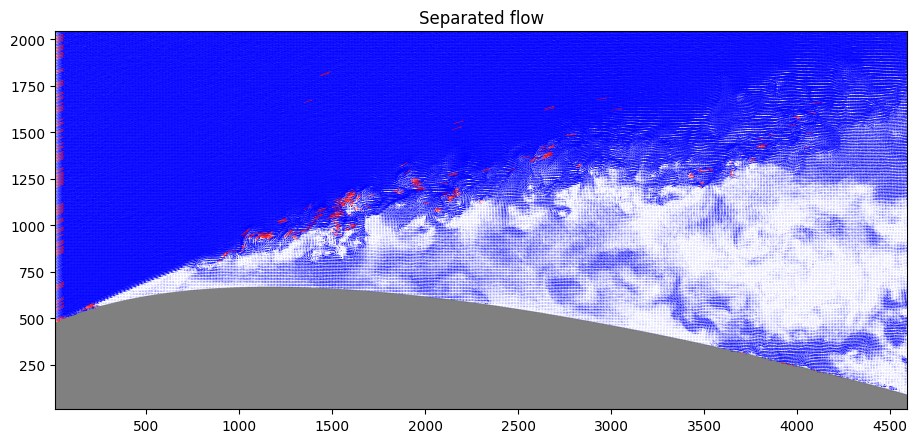

In [9]:
#@title Plot the results
# Create a figure.
fig, ax = plt.subplots(figsize=(11, 11))
ax.set_aspect(1)
vector_width = 0.0005
vector_scale = 1000

# Modify tick labels and ticks.
tick_step = 250
ax.set_xticks(range(0, int(x[0, -1]), 2 * tick_step))
ax.set_yticks(range(0, int(y[0, -1]), tick_step))

# Adjust the axis limits to the minimum and maximum range.
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())

# Show the quiver plot.
ax.quiver(x[_loc], y[_loc], u[_loc], v[_loc], color="b", width=vector_width, scale=vector_scale)
ax.quiver(x[loc], y[loc], u[loc], v[loc], color="r", width=vector_width, scale=vector_scale)
ax.set_title(f"Separated flow")

# Show the mask on the plot.
ax.imshow(~mask, cmap='gray', alpha=0.5, extent=[x.min(), x.max(), y.min(), y.max()])
plt.show()

## <span style="color:blue;">References</span>

> Raffel, M., Willert, C. E., & Kompenhans, J. (1998). Particle image velocimetry: a practical guide (Vol. 2, p. 218). Berlin: Springer.

> Scarano, F., & Riethmuller, M. L. (1999). Iterative multigrid approach in PIV image processing with discrete window offset. Experiments in Fluids, 26, 513-523.

> Meunier, P., & Leweke, T. (2003). Analysis and treatment of errors due to high velocity gradients in particle image velocimetry. Experiments in fluids, 35(5), 408-421.
    
> Garcia, D. (2010). Robust smoothing of gridded data in one and higher dimensions with missing values. Computational statistics & data analysis, 54(4), 1167-1178.

> Shirinzad, A., Jaber, K., Xu, K., & Sullivan, P. E. (2023). An Enhanced Python-Based Open-Source Particle Image Velocimetry Software for Use with Central Processing Units. Fluids, 8(11), 285.